# Data Science Term Project : Movie Rating Prediction

## Import required libraries and connect Google drives

'1.2.2'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from google.colab import drive
from tqdm import tqdm
from collections import defaultdict

warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/가천대학교/데이터과학/termproject/ml-latest-small

movies = pd.read_csv("./movies.csv")
ratings = pd.read_csv("./ratings.csv")

/content/drive/MyDrive/가천대학교/데이터과학/termproject/ml-latest-small


In [6]:
!pip freeze > requirements.txt

## Check the imported data set.

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Data inspection: EDA

### How many users and items are there in the dataset?

In [ ]:
#-- Data inspection : Exploratory Data Analysis
EDA_data = pd.merge(ratings, movies, on='movieId')

n_users = len(EDA_data['userId'].unique())
n_items = len(EDA_data['movieId'].unique())
print(f"# of users : {n_users}\n# of items : {n_items}")

# of users : 610
# of items : 9724


### Does our data not have wrong data?

In [ ]:
EDA_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [ ]:
EDA_data.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


### How many movies are there per year?

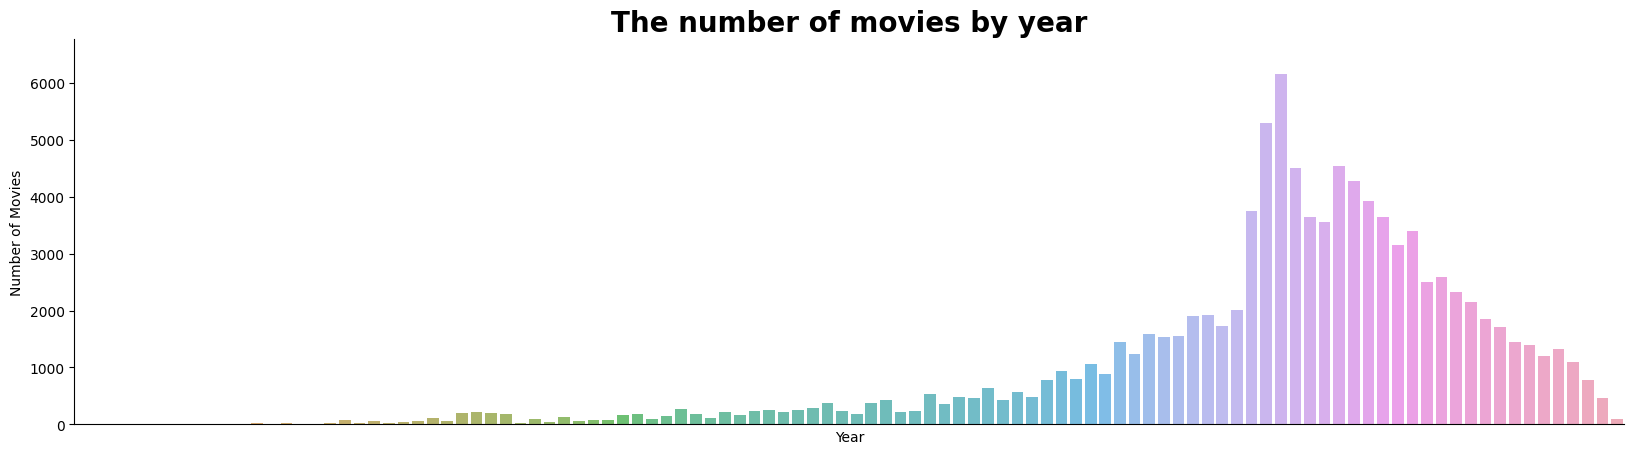

In [ ]:
EDA_data['movieYear'] = EDA_data['title'].apply(lambda x: re.findall(r'\((\d{4})\)', x)[0] if re.findall(r'\((\d{4})\)', x) else 0)
EDA_data['movieYear'] = EDA_data['movieYear'].astype('int64')
EDA_data = EDA_data[EDA_data['movieYear'] != 0]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.margins(0.1, 0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

movie_year_term = EDA_data['movieYear'].value_counts().sort_index()
sns.barplot(x = movie_year_term.index, y = movie_year_term.values, alpha=0.8, ax=ax)

ax.set_title("The number of movies by year", fontweight='semibold', fontsize='20')
ax.set_xticks([])
ax.set_xlabel("Year")
ax.set_ylabel("Number of Movies")

plt.show()

100%|██████████| 100818/100818 [00:12<00:00, 8381.79it/s]


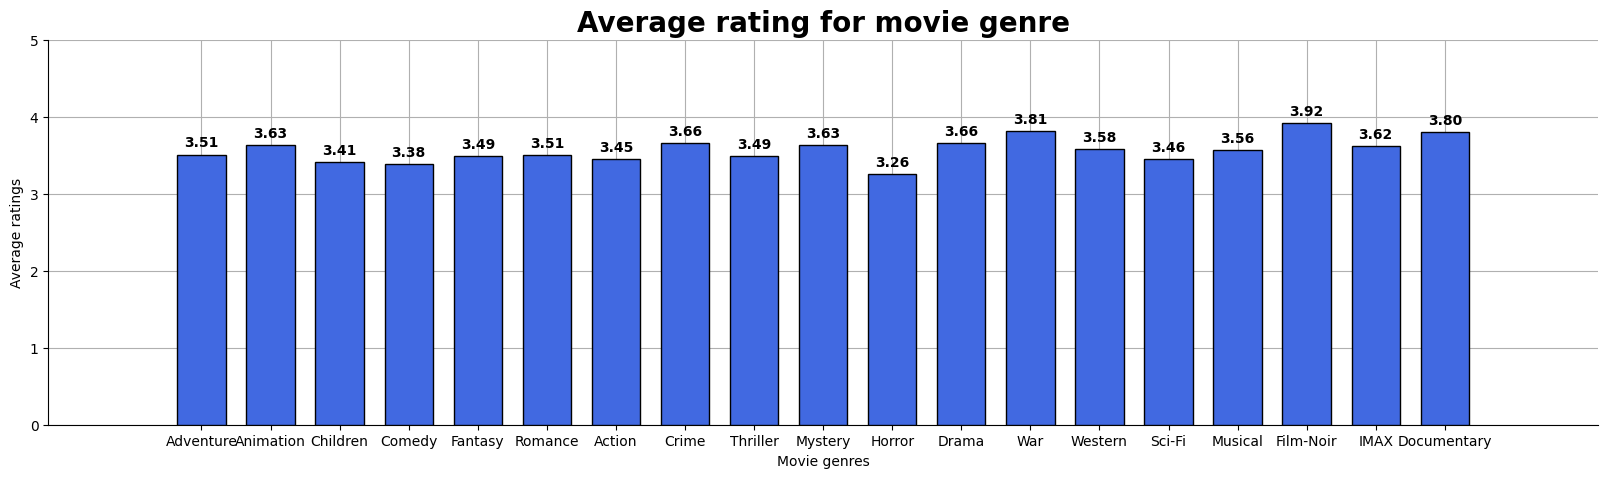

In [ ]:
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genre_rating_sum = defaultdict(list)
for _, record in tqdm(EDA_data.iterrows(), total=len(EDA_data)):
    for genre in genre_columns:
        if genre in record['genres']:
            genre_rating_sum[genre].append(record['rating'])

average_genre_rating = defaultdict(int)
for key in genre_rating_sum.keys():
    average_genre_rating[key] = np.sum(genre_rating_sum[key]) / len(genre_rating_sum[key])


fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.bar(average_genre_rating.keys(), average_genre_rating.values(), 
       color='royalblue',
       width=0.7,
       edgecolor='black',
       linewidth=1,
       zorder=10)

ax.margins(0.1, 0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(zorder=0)

for idx, value in zip(average_genre_rating.keys(), average_genre_rating.values()):
    ax.text(idx, value + 0.1, s='{:.2f}'.format(value), ha='center', fontweight='bold')

ax.set_xlabel('Movie genres')
ax.set_ylabel('Average ratings')
ax.set_title('Average rating for movie genre', fontweight='semibold', fontsize='20')
ax.set_ylim(0, 5)

plt.show()


### How many movies did the user usually watch?

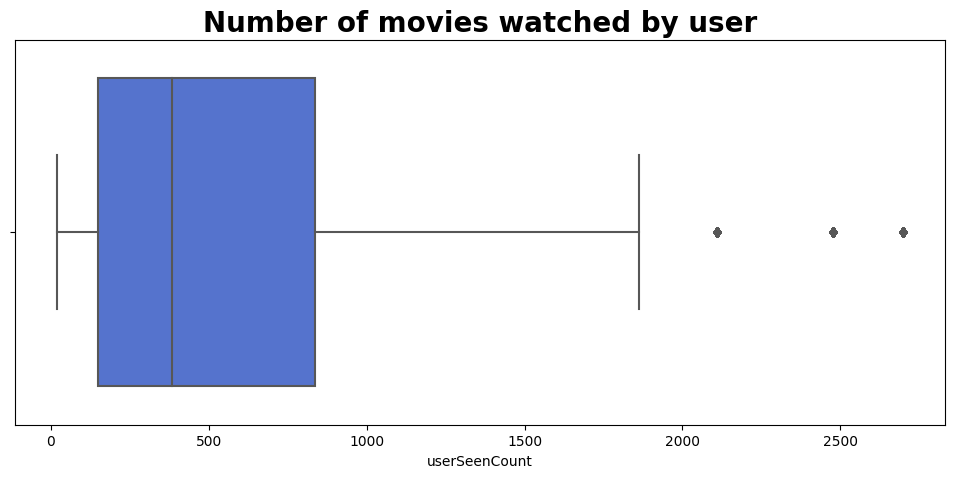

In [ ]:
userSeenCount = EDA_data.groupby('userId')['movieId'].count().reset_index()
userSeenCount.columns = ['userId', 'userSeenCount']
EDA_data = pd.merge(EDA_data, userSeenCount, on='userId')

fig, ax = plt.subplots(1,1, figsize=(12, 5))
sns.boxplot(x='userSeenCount', data=EDA_data, ax=ax, color='royalblue')
ax.set_title("Number of movies watched by user", fontweight='semibold', fontsize='20')
plt.show()

### How many movies are there by genre?

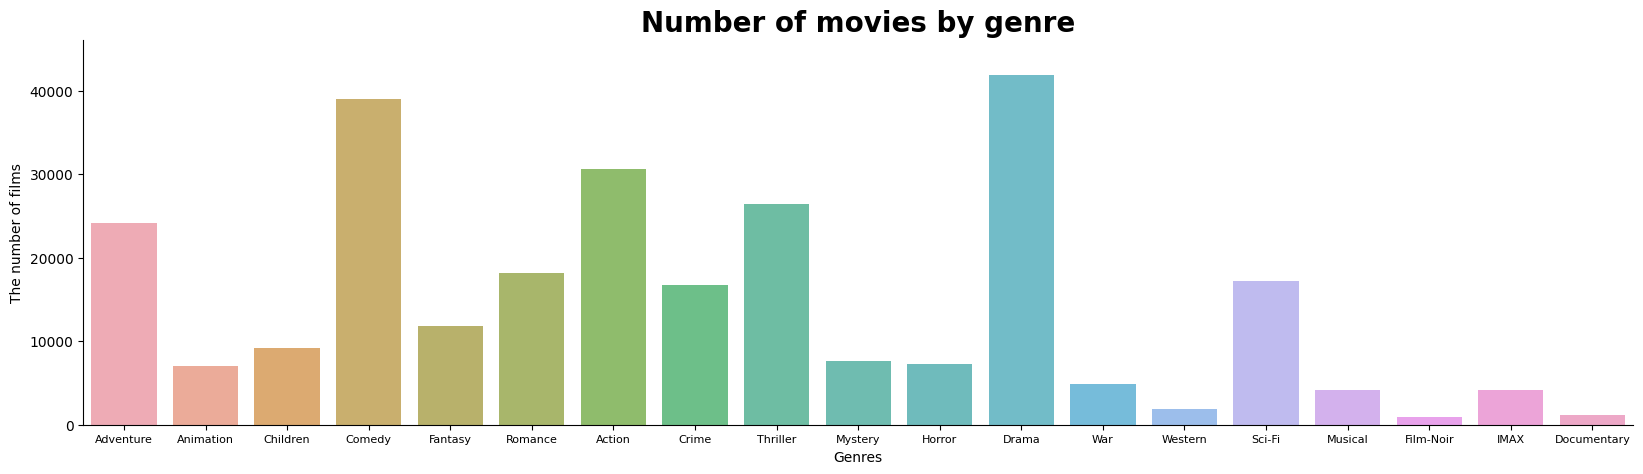

In [ ]:
# about genre
EDA_data['genres'].value_counts()

unique_genre = {}
# iterate to the number of films
for row in EDA_data['genres']:
	# parse the string by |
	parsed_genre = row.split("|")
	# iterate to the number of genres
	for genre_name in parsed_genre :

		if (genre_name in unique_genre) == False :
			unique_genre[genre_name] = 1
		else :
			unique_genre[genre_name] = unique_genre[genre_name] + 1

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.margins(0.1, 0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

del unique_genre['(no genres listed)']
x = list(unique_genre.keys())
y = list(unique_genre.values())
sns.barplot(x=x, y=y, alpha=0.8)
plt.ylabel("The number of films")
plt.xticks(fontsize = 8)
plt.xlabel("Genres")
ax.set_title("Number of movies by genre", fontweight='semibold', fontsize='20')
plt.show()

## Data preprocessing: Feature Engineering

In [ ]:
# movies.csv와 ratings.csv 를 movieId라는 feature를 기준으로 병합한다.
movie_ratings = pd.merge(ratings, movies, on='movieId')


#-- Feature engineering 시작!!
# 장르를 | 를 기준으로 나누어서 장르별 feature를 생성한다.
genre_encoded = movie_ratings['genres'].str.get_dummies('|')
dataset = pd.concat([movie_ratings, genre_encoded], axis=1)


# userId와 movieId에 대한 속성을 category 변수형으로 변환한다.
dataset['userId'] = dataset['userId'].astype('category')
dataset['movieId'] = dataset['movieId'].astype('category')
# category 변수형으로 바꾼 뒤, 0번 부터 다시 번호를 매길 수 있도록 LabelEncoder로 변환한다.
le = LabelEncoder()
dataset['userId'] = le.fit_transform(dataset['userId'])
dataset['movieId'] = le.fit_transform(dataset['movieId'])



# 유저별 영화시청횟수 userSeenCount라는 feature를 추가한다.
userSeenCount = dataset.groupby('userId')['movieId'].count().reset_index()
userSeenCount.columns = ['userId', 'userSeenCount']
dataset = pd.merge(dataset, userSeenCount, on='userId')


# 영화별 관객수 movieSeenCount라는 feature를 추가한다.
movieSeenCount = dataset.groupby('movieId')['userId'].count().reset_index()
movieSeenCount.columns = ['movieId', 'movieSeenCount']
dataset = pd.merge(dataset, movieSeenCount, on='movieId')


# timestamp라는 feature를 logYear, logMonth, logDay 로 변환한다.
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], unit='s')
dataset['logYear'] = dataset['timestamp'].dt.year
dataset['logMonth'] = dataset['timestamp'].dt.month
dataset['logDay'] = dataset['timestamp'].dt.day


# 영화의 출시년도 feature 추가 (title feature로 부터 추출)
dataset['movieYear'] = dataset['title'].apply(lambda x: re.findall(r'\((\d{4})\)', x)[0] if re.findall(r'\((\d{4})\)', x) else 0)
dataset['movieYear'] = dataset['movieYear'].astype('int64')
dataset = dataset[dataset['movieYear'] != 0]

# 불필요한 feature 삭제
dataset = dataset.drop(['title', 'genres', '(no genres listed)', 'timestamp'], axis=1)


# 영화의 출시년도가 적혀있지 않은 데이터 삭제 (18개의 레코드 삭제)

### EDA after preprocessing: What other features are highly correlated with the rating feature?

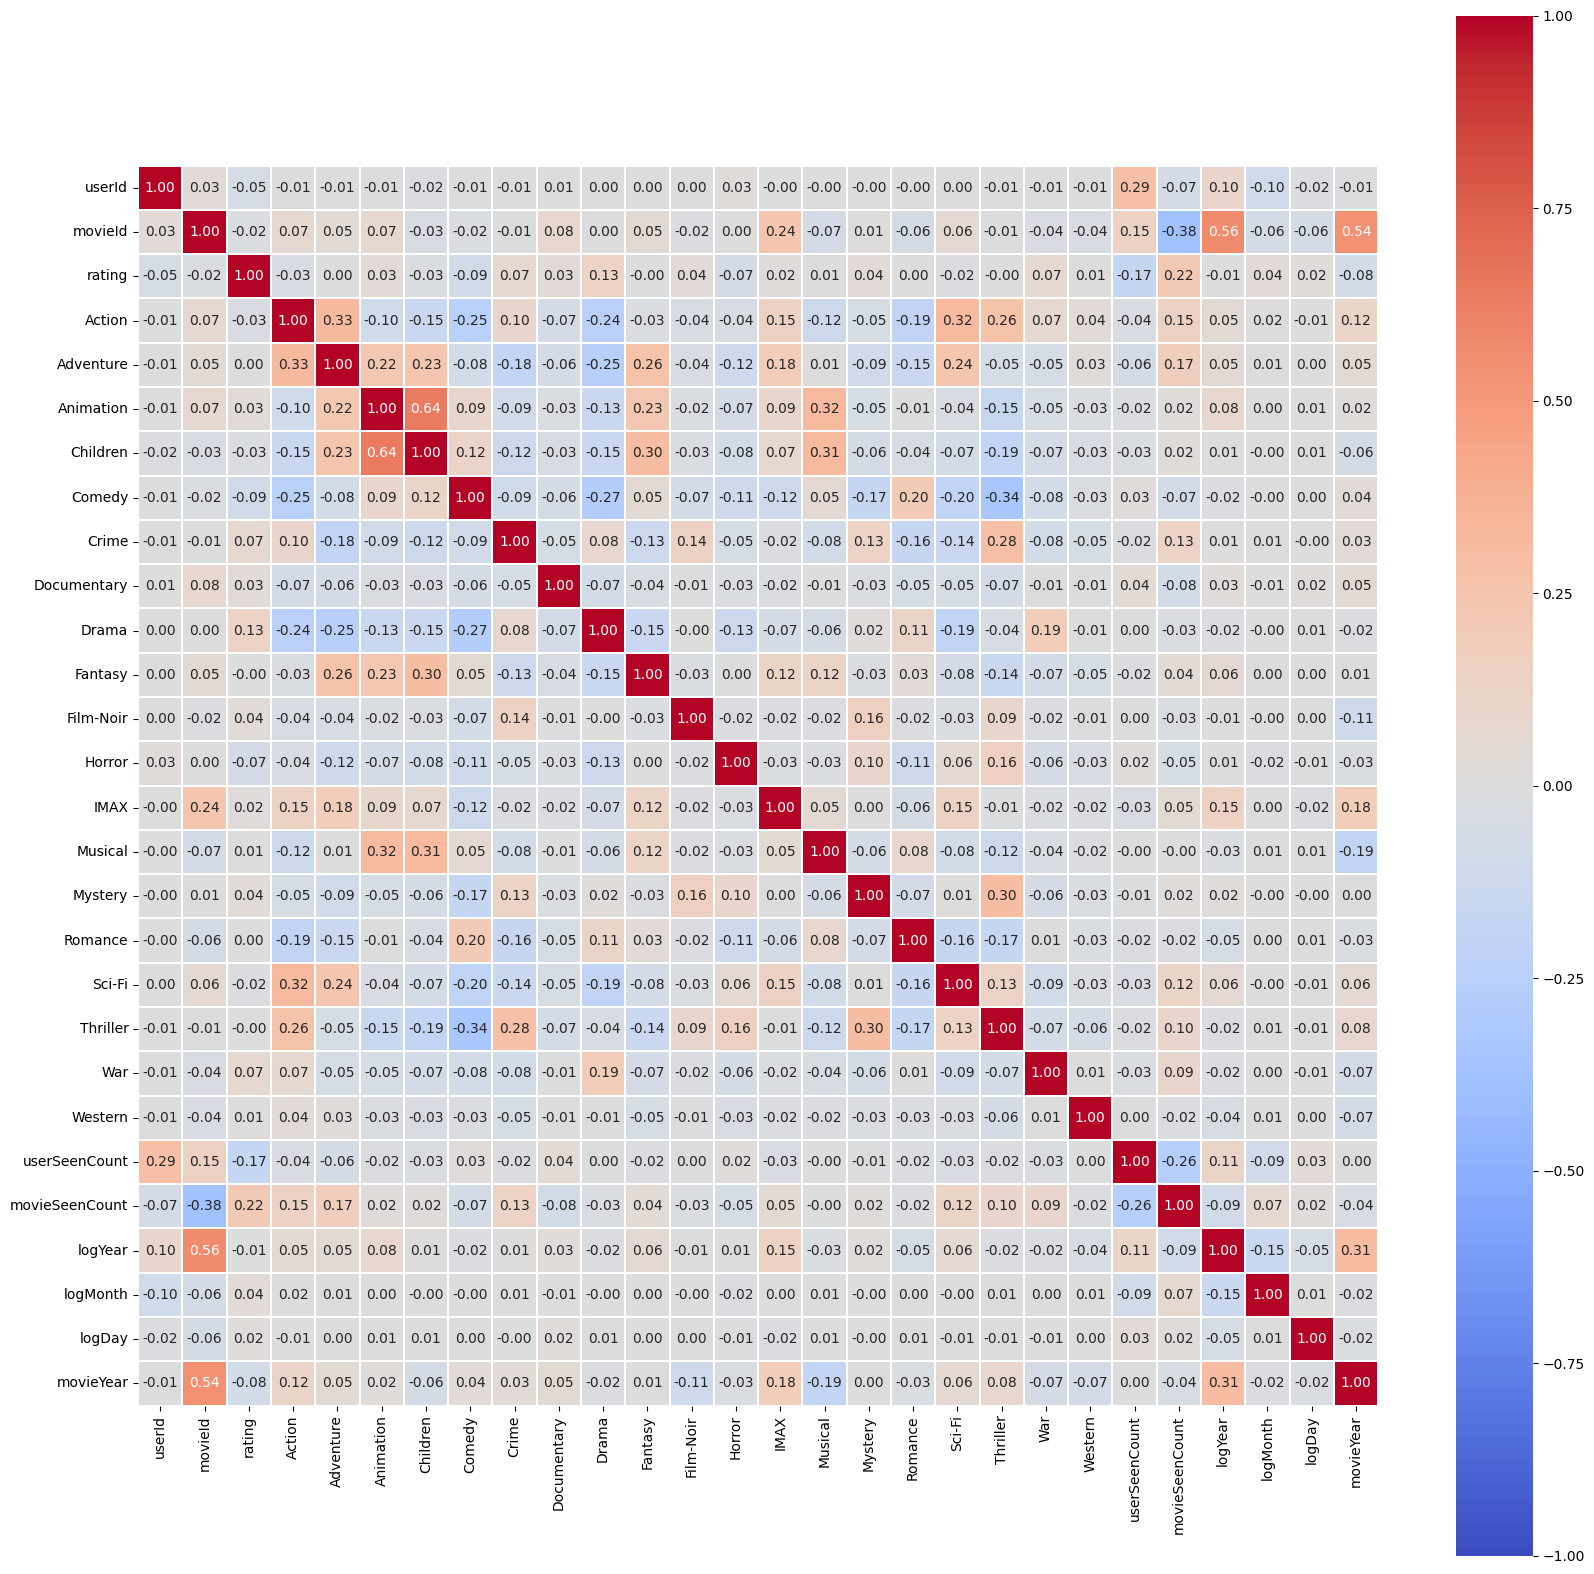

In [ ]:
fig, ax = plt.subplots(1,1 ,figsize=(20, 20))
sns.heatmap(dataset.corr(), ax=ax,
           vmin=-1, vmax=1, center=0,
            cmap='coolwarm', # colormap의 변경
            annot=True, fmt='.2f',
            linewidth=0.1, square=True
           )
plt.show()

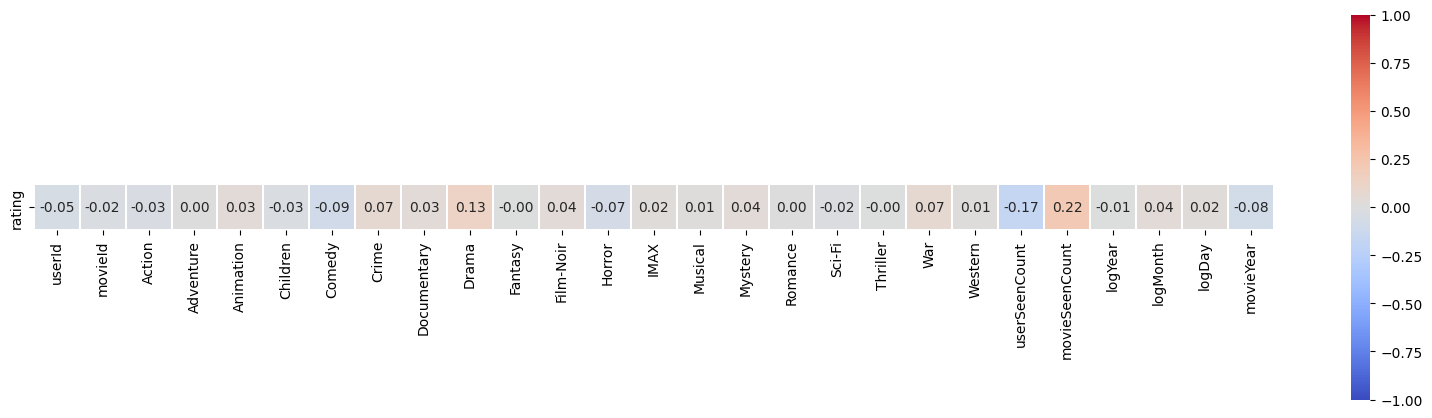

In [ ]:
fig, ax = plt.subplots(1,1 ,figsize=(20, 5))
corr_with_target = dataset.drop(columns='rating').corrwith(dataset['rating'])
sns.heatmap(pd.DataFrame(corr_with_target, columns=['rating']).transpose(), ax=ax,
           vmin=-1, vmax=1, center=0,
            cmap='coolwarm', # colormap의 변경
            annot=True, fmt='.2f',
            linewidth=0.1, square=True
           )
plt.show()

## Data preprocessing: prepare for train & test dataset

In [ ]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset.rating)

In [ ]:
MAX_CLASS_COUNT = 5000

balanced_train_dataset = pd.DataFrame(columns=dataset.columns)
class_distribution = train.rating.value_counts()

# Iterate over each class
for class_label in class_distribution.index:
    # Sample the examples to match the maximum class count
    sampled_examples = train[dataset['rating'] == class_label].sample(MAX_CLASS_COUNT, replace=True, random_state=42)
    # Append the sampled examples to the balanced dataset
    balanced_train_dataset = balanced_train_dataset.append(sampled_examples)

balanced_train_dataset.rating.value_counts()
X_train = balanced_train_dataset.drop(['rating'], axis=1)
y_train = balanced_train_dataset['rating']

X_test = test.drop(['rating'], axis=1)
y_test = test['rating']

In [ ]:
X_train = X_train.astype('int64')
X_test = X_test.astype('int64')

In [ ]:
train_class_distribution = y_train.value_counts()
test_class_distribution = y_test.value_counts()

print("Training Set Class Distribution:")
print(train_class_distribution)

print("\nTest Set Class Distribution:")
print(test_class_distribution)

Training Set Class Distribution:
4.0    5000
3.0    5000
5.0    5000
3.5    5000
4.5    5000
2.0    5000
2.5    5000
1.0    5000
1.5    5000
0.5    5000
Name: rating, dtype: int64

Test Set Class Distribution:
4.0    5363
3.0    4009
5.0    2641
3.5    2627
4.5    1710
2.0    1510
2.5    1110
1.0     562
1.5     358
0.5     274
Name: rating, dtype: int64


## Task1: Regression

- Problems predicting the ratings that users will give to items
- The data set used the movielens dataset.

In [ ]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_predictions))

# Random Forest Regression
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

# XGBoost Regression
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))

# LightGBM Regression
lgb_model = LGBMRegressor()
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))

# AdaBoost Regression
ada_model = AdaBoostRegressor()
ada_model.fit(X_train, y_train)
ada_predictions = ada_model.predict(X_test)
ada_rmse = np.sqrt(mean_squared_error(y_test, ada_predictions))

# Print the evaluation results
print('Linear Regression RMSE:', linear_rmse)
print('Random Forest Regression RMSE:', rf_rmse)
print('XGBoost Regression RMSE:', xgb_rmse)
print('Gradient Boosting Regression RMSE:', gb_rmse)
print('LightGBM Regression RMSE:', lgb_rmse)
print('AdaBoost Regression RMSE:', ada_rmse)


Linear Regression RMSE: 1.1956361316076096
Random Forest Regression RMSE: 0.9593040707919714
XGBoost Regression RMSE: 0.9910499859989018
Gradient Boosting Regression RMSE: 1.1071192026022791
LightGBM Regression RMSE: 1.0131804166990992
AdaBoost Regression RMSE: 1.2219002665239254


In [ ]:
# Store predictions from each model
# linear_predictions = linear_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
# gb_predictions = gb_model.predict(X_test)
lgb_predictions = lgb_model.predict(X_test)
# ada_predictions = ada_model.predict(X_test)

# Calculate mean average ensemble prediction
# mean_predictions = np.mean([linear_predictions, rf_predictions, xgb_predictions, gb_predictions, lgb_predictions, ada_predictions], axis=0)
mean_predictions = np.mean([rf_predictions, xgb_predictions, lgb_predictions], axis=0)

# Calculate weights based on RMSE
rmse_values = [rf_rmse, xgb_rmse, lgb_rmse]
weights = [1 / rmse_value for rmse_value in rmse_values]
weights = np.array(weights) / np.sum(weights)  # Normalize weights to sum up to 1

# Calculate weighted average ensemble prediction
weighted_predictions = np.average([rf_predictions, xgb_predictions, lgb_predictions], axis=0, weights=weights)


In [ ]:
# Calculate RMSE for ensemble predictions
ensemble_rmse = np.sqrt(mean_squared_error(y_test, mean_predictions))
print("mean Ensemble RMSE:", ensemble_rmse)

mean Ensemble RMSE: 0.9518820444287612


In [ ]:
# Calculate RMSE for ensemble predictions
ensemble_rmse = np.sqrt(mean_squared_error(y_test, weighted_predictions))
print("weight Ensemble RMSE:", ensemble_rmse)


weight Ensemble RMSE: 0.9512212871302878


In [ ]:
# Initialize a list to store the squared errors
squared_errors = []

# Iterate over each test instance
for index, row in tqdm(X_test.iterrows(), total=len(X_test)):
    movie_id = row['movieId']
    user_id = row['userId']
    true_rating = y_test.loc[index]
    
    # Get the average rating of the user who watched the movie
    user_ratings = dataset[dataset['userId'] == user_id]['rating']
    user_average_rating = user_ratings.mean()
    
    # Calculate the squared error
    squared_error = (true_rating - user_average_rating) ** 2
    squared_errors.append(squared_error)

# Calculate the RMSE
rmse = np.sqrt(np.mean(squared_errors))
print(f"\nAverage rating prediction RMSE: {rmse}")

100%|██████████| 20164/20164 [00:27<00:00, 738.09it/s]


Average rating prediction RMSE: 1.127924701407777


### Using SVD method

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095449 sha256=847f0e7b205a77be0e988cee38d67c1b1d408a2bbec4b18f0e4ce27afed5218d
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Load the ratings dataset
%cd /content/drive/MyDrive/가천대학교/데이터과학/termproject/ml-latest-small/
ratings_data = pd.read_csv('ratings.csv')

# Create a Surprise Dataset
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

# Split the dataset into train and test sets
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Train the SVD model
model = SVD()
model.fit(train_set)

# Make predictions on the test set
predictions = model.test(test_set)

# Evaluate the model
accuracy = rmse(predictions)
print(f"RMSE: {accuracy}")

# Example prediction for a specific user and movie
user_id = 1
movie_id = 1
predicted_rating = model.predict(user_id, movie_id).est
print(f"Predicted rating for user {user_id} and movie {movie_id}: {predicted_rating}")


/content/drive/MyDrive/가천대학교/데이터과학/termproject/ml-latest-small
RMSE: 0.8811
RMSE: 0.8810684438997475
Predicted rating for user 1 and movie 1: 4.573048920982713


## Binary Classification

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from google.colab import drive
import warnings

warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/가천대학교/데이터과학/termproject/ml-latest-small
# Load the ratings dataset
ratings = pd.read_csv('ratings.csv')

# Load the movies dataset
movies = pd.read_csv('movies.csv')

/content/drive/MyDrive/가천대학교/데이터과학/termproject/ml-latest-small


In [ ]:
# movies.csv와 ratings.csv 를 movieId라는 feature를 기준으로 병합한다.
movie_ratings = pd.merge(ratings, movies, on='movieId')
movie_ratings['watched'] = movie_ratings['rating'].apply(lambda x: 1 if x >= 3.0 else 0)


#-- Feature engineering 시작!!
# 장르를 | 를 기준으로 나누어서 장르별 feature를 생성한다.
genre_encoded = movie_ratings['genres'].str.get_dummies('|')
dataset = pd.concat([movie_ratings, genre_encoded], axis=1)


# userId와 movieId에 대한 속성을 category 변수형으로 변환한다.
dataset['userId'] = dataset['userId'].astype('category')
dataset['movieId'] = dataset['movieId'].astype('category')
# category 변수형으로 바꾼 뒤, 0번 부터 다시 번호를 매길 수 있도록 LabelEncoder로 변환한다.
le = LabelEncoder()
dataset['userId'] = le.fit_transform(dataset['userId'])
dataset['movieId'] = le.fit_transform(dataset['movieId'])
\

# 유저별 영화시청횟수 userSeenCount라는 feature를 추가한다.
userSeenCount = dataset.groupby('userId')['movieId'].count().reset_index()
userSeenCount.columns = ['userId', 'userSeenCount']
dataset = pd.merge(dataset, userSeenCount, on='userId')


# 영화별 관객수 movieSeenCount라는 feature를 추가한다.
movieSeenCount = dataset.groupby('movieId')['userId'].count().reset_index()
movieSeenCount.columns = ['movieId', 'movieSeenCount']
dataset = pd.merge(dataset, movieSeenCount, on='movieId')


# timestamp라는 feature를 logYear, logMonth, logDay 로 변환한다.
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], unit='s')
dataset['logYear'] = dataset['timestamp'].dt.year
dataset['logMonth'] = dataset['timestamp'].dt.month
dataset['logDay'] = dataset['timestamp'].dt.day


# 영화의 출시년도 feature 추가 (title feature로 부터 추출)
dataset['movieYear'] = dataset['title'].apply(lambda x: re.findall(r'\((\d{4})\)', x)[0] if re.findall(r'\((\d{4})\)', x) else 0)
dataset['movieYear'] = dataset['movieYear'].astype('int64')
dataset = dataset[dataset['movieYear'] != 0]

# 불필요한 feature 삭제
dataset = dataset.drop(['rating', 'title', 'genres', '(no genres listed)', 'timestamp'], axis=1)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100818 entries, 0 to 100835
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   userId          100818 non-null  int64
 1   movieId         100818 non-null  int64
 2   watched         100818 non-null  int64
 3   Action          100818 non-null  int64
 4   Adventure       100818 non-null  int64
 5   Animation       100818 non-null  int64
 6   Children        100818 non-null  int64
 7   Comedy          100818 non-null  int64
 8   Crime           100818 non-null  int64
 9   Documentary     100818 non-null  int64
 10  Drama           100818 non-null  int64
 11  Fantasy         100818 non-null  int64
 12  Film-Noir       100818 non-null  int64
 13  Horror          100818 non-null  int64
 14  IMAX            100818 non-null  int64
 15  Musical         100818 non-null  int64
 16  Mystery         100818 non-null  int64
 17  Romance         100818 non-null  int64
 18  Sci-

In [ ]:
X = dataset.drop('watched', axis=1)
y = dataset['watched']

In [ ]:
# Apply stratified K-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = [
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42)
]

hyperparameters = [
    {},
    {'learning_rate': 0.1, 'n_estimators': 10},
    {'C': 1.0},
    {'max_depth': 7}
]

In [ ]:
print("Train start.")

# Initialize a list to store the average accuracy scores for each model
average_accuracies = []

# Perform stratified K-fold cross-validation for each model
for model, params in zip(models, hyperparameters):
    accuracy_scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize and fit the model with hyperparameters
        model.set_params(**params)
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate the accuracy score for the fold
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{model.__class__.__name__}: Accuracy = {accuracy}")
        accuracy_scores.append(accuracy)

    # Calculate the average accuracy score across all folds for the model
    average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    average_accuracies.append(average_accuracy)

# Print the average accuracy scores for each model
for model, average_accuracy in zip(models, average_accuracies):
    print(f"{model.__class__.__name__}: Average accuracy = {average_accuracy}")

RandomForestClassifier: Accuracy = 0.8411029557627455
RandomForestClassifier: Accuracy = 0.8388216623685777
RandomForestClassifier: Accuracy = 0.8394663757191033
RandomForestClassifier: Accuracy = 0.8410454793433517
RandomForestClassifier: Accuracy = 0.8407479045776918
GradientBoostingClassifier: Accuracy = 0.810851021622694
GradientBoostingClassifier: Accuracy = 0.810851021622694
GradientBoostingClassifier: Accuracy = 0.810851021622694
GradientBoostingClassifier: Accuracy = 0.8108416406288746
GradientBoostingClassifier: Accuracy = 0.8108416406288746
LogisticRegression: Accuracy = 0.8107518349533822
LogisticRegression: Accuracy = 0.810851021622694
LogisticRegression: Accuracy = 0.8108014282880381
LogisticRegression: Accuracy = 0.8110400238059813
LogisticRegression: Accuracy = 0.8108912364231513
DecisionTreeClassifier: Accuracy = 0.8223566752628447
DecisionTreeClassifier: Accuracy = 0.8216623685776632
DecisionTreeClassifier: Accuracy = 0.8214639952390399
DecisionTreeClassifier: Accuracy

In [ ]:
import numpy as np

# Create an array to store the predictions of each model
predictions = np.zeros((len(X), len(models)), dtype=int)

# Perform stratified K-fold cross-validation for each model
for i, (model, params) in enumerate(zip(models, hyperparameters)):
    print (f"{model.__class__.__name__} prediction started.")
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize and fit the model with hyperparameters
        model.set_params(**params)
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Store the predictions in the array
        predictions[test_index, i] = y_pred

# Perform ensemble voting
ensemble_predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=predictions)

# Calculate the accuracy of the ensemble predictions
ensemble_accuracy = accuracy_score(y, ensemble_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy}")

# Print the accuracy of each individual model
for i, model in enumerate(models):
    model_accuracy = accuracy_score(y, predictions[:, i])
    print(f"{model.__class__.__name__}: Accuracy = {model_accuracy}")


Ensemble Accuracy: 0.8234343073657482
RandomForestClassifier: Accuracy = 0.840236862465036
GradientBoostingClassifier: Accuracy = 0.8108472693368248
LogisticRegression: Accuracy = 0.8108671070642147
DecisionTreeClassifier: Accuracy = 0.8213711837171933
